# Clean and explore FEC Data and Census Bureau data

## Clean and explore FEC Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import sqlite3
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv('raw_data/fec-pol-contr.csv', index_col=False, na_values=[99999])

print('Num of candidate ids:',len(df['cand_id'].unique()),'\n',
      'Num of committee ids:', len(df['cmte_id'].unique()),'\n',
      'Num of candidate names:', len(df['cand_nm'].unique()),'\n',
      'Shape:', df.shape)

Num of candidate ids: 28 
 Num of committee ids: 28 
 Num of candidate names: 28 
 Shape: (19875, 18)


In [3]:
cand_list = ['Warren, Elizabeth ', 
             'Sanders, Bernard', 
             'Buttigieg, Pete', 
             'Biden, Joseph R Jr']
df = df.loc[df.cand_nm.isin(cand_list)]
print('Num of candidates:', len(df.cand_nm.unique()))

Num of candidates: 4


In [4]:
print(df.form_tp.value_counts())

SA17A    11712
SB28A      206
Name: form_tp, dtype: int64


In [5]:
# drop the refunds (SB28A)
df = df[df.form_tp != 'SB28A']
print(df.form_tp.value_counts())

SA17A    11712
Name: form_tp, dtype: int64


In [6]:
print(df.contbr_city.value_counts())

WASHINGTON     11701
BOLLING AFB       11
Name: contbr_city, dtype: int64


In [7]:
# change bolling afb to washington
indx = df.loc[(df.contbr_city == 'BOLLING AFB')].index
for ind in list(indx):
    df.contbr_city[ind] = 'WASHINGTON'

/Users/alyssaliguori/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [8]:
print(df.contbr_city.value_counts())

WASHINGTON    11712
Name: contbr_city, dtype: int64


In [9]:
df.loc[(df.contbr_zip.isna() != False)]                         
df.loc[df.contbr_nm == 'THOMPSON, KENNETH D JR', 'contbr_zip'] = 20001

In [10]:
df['contbr_zip'] = df.contbr_zip.astype('str')
df.contbr_zip = df['contbr_zip'].apply(lambda x: x[0:5])
print('Unique zip codes:', len(df.contbr_zip.unique()))

Unique zip codes: 49


In [11]:
print('Null zip codes:', df.contbr_zip.isna().sum())

Null zip codes: 0


In [12]:
print(df.contbr_zip.unique())

['20001' '20007' '20006' '20003' '20008' '20013' '20037' '20018' '20010'
 '20002' '20009' '20016' '20024' '20011' '20005' '20015' '20012' '20552'
 '20212' '20004' '20036' '20019' '20526' '20017' '20301' '20540' '20032'
 '20020' '22205' '25413' '20585' '20057' '20375' '20472' '20270' '20026'
 '20229' '20420' '20591' '20500' '20210' '20038' '20044' '20014' '20027'
 '20577' '11217' '20052' '20035']


In [13]:
# (df.contbr_zip == '11217')].index)
df = df[df.contbr_zip !='11217']

In [14]:
len(df.contbr_zip.unique())

48

In [15]:
# filter out negative values
df = df.loc[df.contb_receipt_amt > 0]
print('Min contribution: $', df.contb_receipt_amt.min())

Min contribution: $ 0.01


In [16]:
# filter out values over legal limit of $2800
df = df.loc[df.contb_receipt_amt <= 2800]
print('Max contribution: $', df.contb_receipt_amt.max())

Max contribution: $ 2800.0


In [17]:
df.contb_receipt_amt.describe()

count    11624.000000
mean       204.599122
std        469.674814
min          0.010000
25%         25.000000
50%         50.000000
75%        100.000000
max       2800.000000
Name: contb_receipt_amt, dtype: float64

In [18]:
# convert receipt date to datetime format and then add second column called converted_date
df.contb_receipt_dt = pd.to_datetime(df.contb_receipt_dt)

In [19]:
df.contb_receipt_dt.describe()

count                   11624
unique                    253
top       2019-09-30 00:00:00
freq                      435
first     2018-12-31 00:00:00
last      2019-09-30 00:00:00
Name: contb_receipt_dt, dtype: object

In [20]:
df['converted_date'] = df.contb_receipt_dt.map(lambda x: 100*x.year + x.month)
df['payment_yr'] = df.contb_receipt_dt.map(lambda x: x.year)

In [21]:
df.columns

Index(['cmte_id', 'cand_id', 'cand_nm', 'contbr_nm', 'contbr_city',
       'contbr_st', 'contbr_zip', 'contbr_employer', 'contbr_occupation',
       'contb_receipt_amt', 'contb_receipt_dt', 'receipt_desc', 'memo_cd',
       'memo_text', 'form_tp', 'file_num', 'tran_id', 'election_tp',
       'converted_date', 'payment_yr'],
      dtype='object')

In [22]:
df.head(3)

,cmte_id,cand_id,cand_nm,contbr_nm,contbr_city,contbr_st,contbr_zip,contbr_employer,contbr_occupation,contb_receipt_amt,contb_receipt_dt,receipt_desc,memo_cd,memo_text,form_tp,file_num,tran_id,election_tp,converted_date,payment_yr
103,C00696948,P60007168,"Sanders, Bernard","SUNKETT, BROOKS W",WASHINGTON,DC,20001,CWA,UNION REPRESENTATIVE,100.0,2019-06-07,NaN,NaN,* EARMARKED CONTRIBUTION: SEE BELOW,SA17A,1354564,11449936,P2020,201906,2019
104,C00696948,P60007168,"Sanders, Bernard","SUNKETT, BROOKS W",WASHINGTON,DC,20001,CWA,UNION REPRESENTATIVE,3.0,2019-06-07,NaN,NaN,* EARMARKED CONTRIBUTION: SEE BELOW,SA17A,1354564,11450038,P2020,201906,2019
105,C00696948,P60007168,"Sanders, Bernard","SUNKETT, BROOKS W",WASHINGTON,DC,20001,CWA,UNION REPRESENTATIVE,27.0,2019-06-27,NaN,NaN,* EARMARKED CONTRIBUTION: SEE BELOW,SA17A,1354564,11698884,P2020,201906,2019


In [23]:
df.sort_values(by=['payment_yr']).head()

,cmte_id,cand_id,cand_nm,contbr_nm,contbr_city,contbr_st,contbr_zip,contbr_employer,contbr_occupation,contb_receipt_amt,contb_receipt_dt,receipt_desc,memo_cd,memo_text,form_tp,file_num,tran_id,election_tp,converted_date,payment_yr
16813,C00693234,P00009621,"Warren, Elizabeth","WOOD, JORDAN",WASHINGTON,DC,20001,END CITIZENS UNITED,POLITICAL DIRECTOR,10.0,2018-12-31,NaN,NaN,* EARMARKED CONTRIBUTION: SEE BELOW,SA17A,1343914,2552221,P2020,201812,2018
16691,C00693234,P00009621,"Warren, Elizabeth","TANGLIS, MICHAEL JOSEPH",WASHINGTON,DC,20002,PUBLIC CITIZEN,SENIOR RESEARCHER,100.0,2018-12-31,NaN,NaN,* EARMARKED CONTRIBUTION: SEE BELOW,SA17A,1343914,2557367,P2020,201812,2018
13133,C00693234,P00009621,"Warren, Elizabeth","BALDESSARI, MARTIN",WASHINGTON,DC,20010,NONE,NOT EMPLOYED,250.0,2018-12-31,NaN,NaN,* EARMARKED CONTRIBUTION: SEE BELOW,SA17A,1343914,2557502,P2020,201812,2018
16661,C00693234,P00009621,"Warren, Elizabeth","SAUTTER, CHRIS",WASHINGTON,DC,20008,SELF EMPLOYED,LAWYER/CONSULTANT,100.0,2018-12-31,NaN,NaN,* EARMARKED CONTRIBUTION: SEE BELOW,SA17A,1343914,2557322,P2020,201812,2018
16697,C00693234,P00009621,"Warren, Elizabeth","STERN, GENA",WASHINGTON,DC,20007,JPMORGAN CHASE,"CHIEF OF STAFF, JPMCI",250.0,2018-12-31,NaN,NaN,* EARMARKED CONTRIBUTION: SEE BELOW,SA17A,1343914,2557479,P2020,201812,2018


In [24]:
df_grouped_yr = df.groupby(['cand_nm','payment_yr']).mean()
df_grouped_yr[['contb_receipt_amt']]

contb_receipt_amt
cand_nm            payment_yr                   
Biden, Joseph R Jr 2019               455.352748
Buttigieg, Pete    2019               317.258267
Sanders, Bernard   2019                60.139579
Warren, Elizabeth  2018               358.500000
                   2019               101.565576

In [25]:
df.shape

(11624, 20)

In [26]:
# filter out 2016, 2017, and 2018 
df = df[df.payment_yr >= 2019]
df.shape

(11614, 20)

In [27]:
# tran_id is not a unique value 
df[df.duplicated(subset = 'tran_id', keep=False)]
df = df.drop(['cand_id', 
              'file_num', 
              'contbr_nm',
              'contb_receipt_dt',
              'form_tp',
              'election_tp',
              'contbr_city', 
              'memo_cd', 
              'receipt_desc', 
              'contbr_st', 
              'memo_text',
              'cmte_id', 
              'tran_id',
              'contbr_employer',
              'contbr_occupation',
              'payment_yr'
             ], 
        axis=1)
df.shape

(11614, 4)

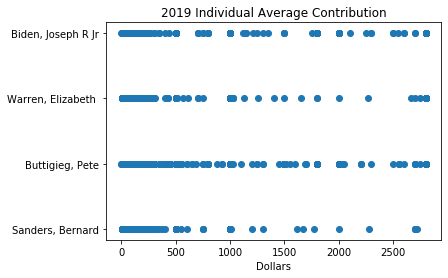

In [28]:
# graph average contribution by candidate 
plt.scatter(df.contb_receipt_amt, df.cand_nm)
plt.title('2019 Individual Average Contribution')
plt.xlabel('Dollars')
plt.show()

In [29]:
df_grouped_cand = df.groupby('cand_nm').mean()
df_grouped_cand['contb_receipt_amt']

cand_nm
Biden, Joseph R Jr    455.352748
Buttigieg, Pete       317.258267
Sanders, Bernard       60.139579
Warren, Elizabeth     101.565576
Name: contb_receipt_amt, dtype: float64

In [30]:
df.cand_nm.value_counts()

Buttigieg, Pete       3750
Warren, Elizabeth     3612
Sanders, Bernard      2829
Biden, Joseph R Jr    1423
Name: cand_nm, dtype: int64

In [31]:
df.groupby('cand_nm').min()['converted_date']

cand_nm
Biden, Joseph R Jr    201904
Buttigieg, Pete       201901
Sanders, Bernard      201902
Warren, Elizabeth     201901
Name: converted_date, dtype: int64

In [32]:
# contribution amount by month for each candidate 
df.groupby(['cand_nm','converted_date']).mean()['contb_receipt_amt']

cand_nm             converted_date
Biden, Joseph R Jr  201904            711.465022
                    201905            447.095444
                    201906            596.462398
                    201907            197.217160
                    201908            516.234118
                    201909            249.941526
Buttigieg, Pete     201901            321.428571
                    201902            571.052632
                    201903            481.066948
                    201904            533.287420
                    201905            683.124096
                    201906            327.772475
                    201907            160.074282
                    201908             94.050600
                    201909            148.499467
Sanders, Bernard    201902            310.810536
                    201903             66.041284
                    201904             62.499773
                    201905             56.709263
                    201906        

In [33]:
df.head()

,cand_nm,contbr_zip,contb_receipt_amt,converted_date
103,"Sanders, Bernard",20001,100.0,201906
104,"Sanders, Bernard",20001,3.0,201906
105,"Sanders, Bernard",20001,27.0,201906
134,"Sanders, Bernard",20007,3.0,201903
135,"Sanders, Bernard",20001,27.0,201906


## Join US Census data to FEC data

In [34]:
conn = sqlite3.connect('')
cur = conn.cursor()

In [35]:
census_data = pd.read_csv('raw_data/census-bureau-acs.csv', 
                          header =0, 
                          index_col=0, 
                          usecols=['GEO.id', 'GEO.id2','HC02_EST_VC02'], 
                          skiprows=[1,2],na_values='-'
                         )
census_data.to_sql('INCOME', conn, if_exists = 'append')

In [36]:
df_census = pd.DataFrame(census_data)
df_census = df_census.rename(columns={'GEO.id2': 'zip', 'HC02_EST_VC02': 'income'})

In [37]:
len(df_census.income.value_counts())
print('Census data types:', '\n',df_census.dtypes, '\n')
print('FEC data types:','\n', df.dtypes)
df.contbr_zip = df.contbr_zip.astype(int)

Census data types: 
 zip         int64
income    float64
dtype: object 

FEC data types: 
 cand_nm               object
contbr_zip            object
contb_receipt_amt    float64
converted_date         int64
dtype: object


In [38]:
df_merged = df.merge(df_census, 
                     how='left', 
                     left_on='contbr_zip', 
                     right_on='zip', 
                     suffixes=('_left','_right')
                    )

In [39]:
print(df_merged.isna().sum())
print(df_merged.dtypes)
pd.to_numeric(df_merged.income);

cand_nm                0
contbr_zip             0
contb_receipt_amt      0
converted_date         0
zip                  105
income               112
dtype: int64
cand_nm               object
contbr_zip             int64
contb_receipt_amt    float64
converted_date         int64
zip                  float64
income               float64
dtype: object


In [40]:
print(df_merged.shape)
print(df_merged.isna().sum())
df_merged.head()

(11614, 6)
cand_nm                0
contbr_zip             0
contb_receipt_amt      0
converted_date         0
zip                  105
income               112
dtype: int64


,cand_nm,contbr_zip,contb_receipt_amt,converted_date,zip,income
0,"Sanders, Bernard",20001,100.0,201906,20001.0,85976.0
1,"Sanders, Bernard",20001,3.0,201906,20001.0,85976.0
2,"Sanders, Bernard",20001,27.0,201906,20001.0,85976.0
3,"Sanders, Bernard",20007,3.0,201903,20007.0,119267.0
4,"Sanders, Bernard",20001,27.0,201906,20001.0,85976.0


In [41]:
# how many income values are each candidate missing? 
print(len(df_merged.loc[(df_merged.cand_nm == 'Warren, Elizabeth ') 
                        & (df_merged.zip.isna() == True)
                       ]))
print(len(df_merged.loc[(df_merged.cand_nm == 'Biden, Joseph R Jr') 
                        & (df_merged.zip.isna() == True)
                       ]))
print(len(df_merged.loc[(df_merged.cand_nm == 'Buttigieg, Pete') 
                        & (df_merged.zip.isna() == True)
                       ]))
print(len(df_merged.loc[(df_merged.cand_nm == 'Sanders, Bernard') 
                        & (df_merged.zip.isna() == True)
                       ]))

3
2
1
99


In [42]:
nulls = df_merged.loc[df_merged.income.isna() == True].index
len(nulls)
# drop null income values, most of them went to Bernie Sanders 
df_merged = df_merged.drop(index=nulls)
len(df_merged)

11502

In [43]:
print(df_merged.shape)
df_merged.cand_nm.value_counts()

(11502, 6)


Buttigieg, Pete       3746
Warren, Elizabeth     3609
Sanders, Bernard      2726
Biden, Joseph R Jr    1421
Name: cand_nm, dtype: int64

In [44]:
df_merged.drop(columns=['zip'], inplace=True)

In [45]:
print(df_merged.shape)
df_merged.head()

(11502, 5)


,cand_nm,contbr_zip,contb_receipt_amt,converted_date,income
0,"Sanders, Bernard",20001,100.0,201906,85976.0
1,"Sanders, Bernard",20001,3.0,201906,85976.0
2,"Sanders, Bernard",20001,27.0,201906,85976.0
3,"Sanders, Bernard",20007,3.0,201903,119267.0
4,"Sanders, Bernard",20001,27.0,201906,85976.0


In [46]:
le = LabelEncoder()
df_merged['target'] = None
df_merged.target = le.fit_transform(df_merged.cand_nm)
df_merged.head()

,cand_nm,contbr_zip,contb_receipt_amt,converted_date,income,target
0,"Sanders, Bernard",20001,100.0,201906,85976.0,2
1,"Sanders, Bernard",20001,3.0,201906,85976.0,2
2,"Sanders, Bernard",20001,27.0,201906,85976.0,2
3,"Sanders, Bernard",20007,3.0,201903,119267.0,2
4,"Sanders, Bernard",20001,27.0,201906,85976.0,2


In [47]:
df_merged.dtypes


cand_nm               object
contbr_zip             int64
contb_receipt_amt    float64
converted_date         int64
income               float64
target                 int64
dtype: object

In [48]:
df_merged.to_csv('clean_data/2019-fec-contr-census.csv')